In [1]:
import sys
import os
import yaml
import getpass
import gmaps
import pandas as pd
import matplotlib.pyplot as plt

#adding prognos tools
sys.path.insert(0, "/home/jose-luis/Envs/niva_prognos/PROGNOS/")
from prognos_tools.encrypt import decryptString,encryptString
from prognos_tools.Basin import Basin

from geonorge_scraping import Download

geonorge_encrypted=b'gAAAAABc2SuJN0rMAgv8fEeN9U_YTle-kcHc1Hy63ON7Y_LpkKAfmWBY01Eud7yA_CvU_rsoM_VstFzTLsX28BGb7d9aVIfqnp76smF4rn0sF8Sp4fRZnHI-B8TfVlew-qcDmewcvCj8'
key = getpass.getpass('Password: ')
geonorge_credentials = yaml.safe_load(decryptString(geonorge_encrypted,key))

# The encryption key has a 90 days timespan and might need to be re-encrypted
# with open('geocredentials.yaml','w') as f:
#     f.write(yaml.dump(geonorge_credentials))
    
# Basin.callPopen('gcloud kms encrypt --location global --keyring jlg-keyring --key prognos-key --plaintext-file geocredentials.yaml --ciphertext-file geocredentials.yaml.encrypted')


gmapsToken=b'gAAAAABctxJp5wE73qK6U5VieCi0WXNnNex4KxLZHutsESa8fW9v43lLa1Ag0qsxKFjXXo9MBAdvUpqJPW-QmCE0gH_Opf9g4xAG1VaI2WarO_xDZg44VLMCHkd_6O8ofgp8u4VuFBMr'
apiKey = decryptString(gmapsToken,key)
gmaps.configure(api_key=apiKey)
del key,apiKey

Password:  ·······


# Starting instance with geodatabase

In [2]:
machineInfo={}
#Vm characteristics
machineInfo['instance'] = 'gruber'
machineInfo['username'] = 'jose-luis'
machineInfo['image'] = 'geonorway'
machineInfo['imageProject'] = 'nivacatchment'
machineInfo['diskSize'] = '300GB'
machineInfo['keyDir'] = '/home/jose-luis/.ssh/AR5-basins'
machineInfo['region'] = 'europe-north1-c'
machineInfo['machineType'] = 'n1-standard-4'
machineInfo['keyFile'] = F'{os.path.join(machineInfo["keyDir"],machineInfo["username"])}'
machineInfo['pubKeyFile'] = F'{machineInfo["keyFile"] + ".pub"}'

geonorge = Basin(machineInfo)

geonorge.vmScript = '''#!/bin/bash
sudo killall apt-get

export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s`
echo "deb http://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

yes | sudo apt-get update
yes | sudo apt-get install gcsfuse
'''

Basin.initString += '''--scopes=https://www.googleapis.com/auth/devstorage.read_write,\
https://www.googleapis.com/auth/cloudkms\n'''

geonorge.instantiate(fabfile='/home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py')
print("The ip of the google cloud instance is {}".format(geonorge.ip))

#Testing connection to instance
geonorge.callPopen('gcloud compute ssh {username}@{instance} --zone {region}'.format(
**geonorge.machineInfo))

#Installing dependencies necessary to crawl through geonorge
scriptsFolder='./scripts'
geonorge.runScript(saveFolder=scriptsFolder,scriptName='setup.sh')


[35.228.105.138] out: 
[35.228.105.138] out: Reading state information... Done
[35.228.105.138] out: 
[35.228.105.138] out: gcsfuse is already the newest version (0.27.0).
[35.228.105.138] out: 0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.



## Uploading land cover data to vm and putting it in database

In [3]:
#Downloading data using geonorge_scraping.py utilities
#IMPORTANT DISCLAIMER: getting stdout in console, while it gives you an idea of the progress, is SLOOOOOOOWWWWW. For production (if it evers comes to that), it is better to make this silent
#and find another way of monitoring progress (start in a tmux session and check once in while?, another option might be to make the uploading of the sql dumps silent)

geonorge.vmScript='''#!/bin/bash
#Downloading shapefiles 
rm -rf dummy
mkdir dummy
gcsfuse jlg-bucket dummy
cp ./dummy/AR5-shapefiles.tar AR5.tar
fusermount -u ./dummy
tar -xf AR5.tar

#Uploading shapefile boundaries to database
echo "DROP SCHEMA IF EXISTS nibio CASCADE;" | psql -d geonorway
echo "CREATE SCHEMA nibio;" | psql -d geonorway
#echo "DROP TABLE nibio.boundaries;" | psql -d geonorway
echo "CREATE TABLE nibio.boundaries(geom geometry(Polygon, 3035),file varchar(128))" | psql -d geonorway
find ./shapefiles -type f -name "*KantUtsnitt*.shp" > shpList.txt
while IFS= read -r shape; do
  echo Processing $shape
  #Find projection from .prj file
  prjFile="${shape%.shp}.prj"  
  epsg=326$(grep -o 'UTM zone [0-9][0-9]' $prjFile | tail -c 3)
  landUseFile=`echo $shape | sed s/KantUtsnitt_KURVE/ArealressursFlate_FLATE/`

  #Actually putting the shapefile in the database. Changing projection to 3035
  shp2pgsql -s $epsg:3035 -I $shape nibio.dummy | psql -q -d geonorway 
  echo "INSERT INTO nibio.boundaries SELECT ST_MakeValid(ST_ConvexHull(ST_Union(geom))), \'$landUseFile\' FROM nibio.dummy;" | psql -d geonorway
  echo "DROP TABLE nibio.dummy;" | psql -d geonorway
done < shpList.txt   #<<<$(tail -n1 shpList.txt)
echo "CREATE INDEX nibio_boundaries_idx ON nibio.boundaries USING GIST (geom);" | psql -q -d geonorway 


#find ./data_AR5/ -type f -name '*.zip' | parallel --ungroup unzip {}
#rm -rf AR5-sos
#mkdir AR5-sos
#mv *.sos ./AR5-sos/

#cd AR5-sos
#wget https://github.com/espena/sosicon/blob/master/bin/cmd/linux64/sosicon?raw=true -O sosicon && chmod +x sosicon

#rm -rf shapefiles
#mkdir shapefiles
#find ./AR5-sos -type f -name "*.sos" | parallel ./AR5-sos/sosicon -2shp -d ./shapefiles  {}
#tar cfv -  ./shapefiles | gzip -9c > AR5-shapefiles.tar

#find ./ -type f -name "*.sos" | parallel --ungroup ./sosicon  -t KantUtsnitt -2psql -schema nibio \\
#-table '{= s:\A[^\_]+\_[^\_]+\_::;s:\_[^\_]+\_[^\_]+\_[^\_]+\Z::;s:.*:\L$_:;s:[\_-]::g; =}' {} > /dev/null
#find ./ -type f -name "postgis_dump*.sql" -exec sed -i 's/CREATE SCHEMA nibio;/CREATE SCHEMA IF NOT EXISTS nibio;/g' {} \;
#rm *.sos
#find ./ -type f -name "postgis_dump*.sql" | parallel psql -d geonorway -f {}
#cd ..
#rm -r AR5-sos
'''
# with open('bla.sh','w') as f:
#     f.write(geonorge.vmScript)
    
geonorge.runScript(saveFolder=scriptsFolder,scriptName='uploadAR5.sh')


[35.228.130.199] out:  nibio.dummy.geom SRID:3035 TYPE:MULTILINESTRING DIMS:2 
[35.228.130.199] out: (1 row)
[35.228.130.199] out: 
[35.228.130.199] out: INSERT 0 1
[35.228.130.199] out: DROP TABLE
[35.228.130.199] out: 


Done.
Disconnecting from 35.228.130.199... done.



### Getting extent of all individual shapefiles

In [4]:
#For this we will create a procedure since we need dynamic table names
geonorge.vmScript='''#!/bin/bash

#Creating store procedure that will create a dissolved polygon for every region uploaded in the previous step
read -r -d '' sql <<-EOM
CREATE OR REPLACE FUNCTION nibio.get_all_shapes(_shape text, _table text) RETURNS void AS \$\$ 
DECLARE
  dynamic_query text := '';
  r_row         record;
  counter integer := 0;
  st text := FORMAT('nibio.%s',_table);
  st_idx text := FORMAT('nibio_%s_geom_idx',_table);
BEGIN
  EXECUTE FORMAT('DROP TABLE IF EXISTS %s;',st);
  EXECUTE FORMAT('CREATE TABLE %s(area_name varchar, geom geometry);',st);
  FOR r_row in SELECT table_schema || '.' || split_part(table_name,'_',1) || '_' || _shape as qualified_table_name,
                      split_part(table_name,'_',1) || '_geom' as qualified_column_name,
                      split_part(table_name,'_',1) AS qualified_area_name
    FROM information_schema.tables
    WHERE table_schema = 'nibio'
    AND split_part(table_name,'_',2) = 'linestring'
      LOOP
        counter := counter + 1;
        dynamic_query := FORMAT('INSERT INTO %s SELECT ''%s'', ST_CONVEXHULL(ST_UNION(%s)) FROM %s',
                                 st,
                                 r_row.qualified_area_name,
                                 r_row.qualified_column_name,
                                 r_row.qualified_table_name);
        RAISE NOTICE '%->%', counter,dynamic_query;
        EXECUTE dynamic_query;
      END LOOP;
      EXECUTE FORMAT('CREATE INDEX %s ON %s USING gist(geom);',st_idx,st); 
  RETURN;
END;
\$\$ LANGUAGE PLPGSQL;
EOM

#echo "DROP FUNCTION IF EXISTS nibio.get_all_shapes(text,text);" | psql -d geonorway
echo $sql | psql -d geonorway


#Deleting unnecessary tables
read -r -d '' sql <<-EOM
CREATE OR REPLACE FUNCTION nibio.delete_from_nibio(_toDel text) RETURNS void AS \$\$ 
DECLARE
  r_row record;
  dynamic_query text := '';
  string_to_del text := FORMAT('%s%s%s','%',"_toDel",'%');
BEGIN
  FOR r_row in SELECT c.oid::regclass::text as toBeKilled  
               FROM   pg_catalog.pg_class c
               JOIN   pg_catalog.pg_namespace n ON n.oid = c.relnamespace
               WHERE  n.nspname = 'nibio' 
               AND c.oid::regclass::text   like string_to_del
               AND c.relkind='r'
   LOOP
     dynamic_query := FORMAT('DROP TABLE %s;', r_row.toBeKilled);
     RAISE NOTICE '%', dynamic_query;
     EXECUTE dynamic_query;
   END LOOP;  
  RETURN;
END;
\$\$ LANGUAGE PLPGSQL;
EOM

echo $sql | psql -d geonorway


#And actually finding out the boundaries of each region:
echo "SELECT \"nibio.get_all_shapes\"('linestring','extents');" | psql -d geonorway
echo "SELECT nibio.delete_from_nibio('polygon');" | psql -d geonorway;
echo "SELECT nibio.delete_from_nibio('point');" | psql -d geonorway;
'''
# with open('getBoundaries.sh','w') as file:
#     file.write(vmScript)

#Don't need to run this anymore because the boundaries were uploaded in the routine in the previous cell
#geonorge.runScript(saveFolder=scriptsFolder,scriptName='getBoundaries.sh')

## Delineating basins

In [47]:
#Schema were processing will be done
schema = 'metno'

#Getting basin outlets from yaml file
stationsFile = './hans-fredrik.yaml'
stations = yaml.safe_load(open(stationsFile))
display(stations)

#Actually processing the basin
geoResultsFolder=os.path.abspath('./geoResults')
# geonorge.callPopen('mkdir -p {}'.format(geoResultsFolder))
# display(geoResultsFolder)
geonorge.getBasinLayers(stationsFile,schema,saveFolder=geoResultsFolder)

[{'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6558233,
   'longitude': 310091,
   'station_id': 3555,
   'station_name': 'Breidtjern'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6671439,
   'longitude': 332507,
   'station_id': 4203,
   'station_name': 'Bæreia'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6561016,
   'longitude': 183749,
   'station_id': 110,
   'station_name': 'Flåte'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6621713,
   'longitude': 282023,
   'station_id': 137,
   'station_name': 'Lyseren'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6622350,
   'longitude': 235553,
   'station_id': 5706,
   'station_name': 'Røysjø'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6620746,
   'longitude': 224023,
   'station_id': 5742,
   'station_name': 'Store_Øyvannet'}},
 {'station': {'buffer': 30000,
   'epsg': 32633,
   'latitude': 6617213,
   'longitu

'Directory should be created'

Gonna create the getBasin.sh file
/home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/geoResults/getBasin.sh
fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py runScript:/home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/geoResults/getBasin.sh,True
[35.228.105.138] Executing task 'runScript'
[35.228.105.138] Executing task 'setup'
[35.228.105.138] put: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/geoResults/getBasin.sh -> getBasin.sh
[35.228.105.138] run: chmod +x getBasin.sh
[35.228.105.138] run: ./getBasin.sh
[35.228.105.138] out: NOTICE:  table "stations" does not exist, skipping
[35.228.105.138] out:  initializestations 
[35.228.105.138] out: --------------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out:  addstations 
[35.228.105.138] out: -------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] ou

### Visualizing basins

In [27]:
with open(os.path.join(geoResultsFolder,'gmaps.txt'), 'r') as f:
    lines = f.read().splitlines()
    
fig = gmaps.figure()
fig.add_layer(gmaps.geojson_layer(yaml.safe_load(lines[0])))

lines[2:] = [i.split(';') for i in lines[2:]]
outlets = [{"name": i[0], "area": i[3]} for i in lines[2:]]
locations = [(float(i[2]),float(i[1])) for i in lines[2:]]
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Area</dt><dd>{area} km<sup>2</sup></dd>
</dl>
"""                                                
outlet_info = [info_box_template.format(**outlet) for outlet in outlets]                                                 
marker_layer = gmaps.marker_layer(locations, info_box_content=outlet_info)
fig.add_layer(marker_layer)

fig

Figure(layout=FigureLayout(height='420px'))

### Uploading AR5 shapefiles that intersect the basins

In [7]:
### Finding out which shapes intersect the coverage and uploading them
geonorge.vmScript='''#!/bin/bash
echo "\COPY (SELECT DISTINCT a.file \
FROM metno.resultsshp as b, nibio.boundaries as a \
WHERE ST_INTERSECTS(geom,b.basin) \
) TO '/home/jose-luis/upload.txt';" | psql -d geonorway
        
#Uploading the necessary files to the database
echo "DROP TABLE IF EXISTS nibio.landuse;" | psql -d geonorway
echo "CREATE TABLE nibio.landuse(argrunnf varchar(2), arskogbon varchar(2), artreslag varchar(2),artype varchar(2), geom geometry);" | psql -d geonorway
while IFS= read -r shape; do
  echo Processing $shape
  #Find projection from .prj file
  prjFile="${shape%.shp}.prj"  
  epsg=326$(grep -o 'UTM zone [0-9][0-9]' $prjFile | tail -c 3)
  #Actually putting the shapefile in the database. Changing projection to 3035
  shp2pgsql -d -s $epsg:3035 $shape nibio.dummy | psql -q -d geonorway 
  echo "INSERT INTO nibio.landuse SELECT DISTINCT a.\\\"argrunnf  \\\",a.\\\"arskogbon \\\" ,a.\\\"artreslag \\\",a.\\\"artype    \\\", \
  ST_Multi(ST_MakeValid(a.geom)) FROM nibio.dummy AS a \
  WHERE ST_GeometryType(a.geom) = 'ST_Polygon' \
  OR ST_GeometryType(a.geom) = 'ST_MultiPolygon';" | psql -q -d geonorway
done< upload.txt 

echo "DROP TABLE nibio.dummy;" | psql -q -d geonorway   
echo "SELECT UpdateGeometrySRID('nibio','landuse','geom',3035);" | psql -q -d geonorway
echo "DELETE FROM nibio.landuse WHERE ST_GeometryType(geom) != 'ST_MultiPolygon';" | psql -d geonorway
echo "CREATE INDEX nibio_landuse_idx ON nibio.landuse USING GIST (geom);" | psql -q -d geonorway 
'''
# with open('bla.sh','w') as f:
#     f.write(geonorge.vmScript)echo "SELECT ST_SetSRID(geom,3035) FROM nibio.landuse;" | psql -q -d geonorway
    
geonorge.runScript(saveFolder=scriptsFolder,scriptName='findIntersection.sh')

#echo "INSERT INTO nibio.landuse SELECT a.\\\"argrunnf  \\\",a.\\\"arskogbon \\\" ,a.\\\"artreslag \\\",a.\\\"artype    \\\", \
#  ST_Multi(ST_MakeValid(a.geom)) FROM nibio.dummy AS a \
#  WHERE ST_GeometryType(a.geom) = 'ST_Polygon' \
#  OR ST_GeometryType(a.geom) = 'ST_MultiPolygon';" | psql -q -d geonorway



[35.228.130.199] out: -----------------------------------------
[35.228.130.199] out:  nibio.landuse.geom SRID changed to 3035
[35.228.130.199] out: (1 row)
[35.228.130.199] out: 
[35.228.130.199] out: DELETE 122
[35.228.130.199] out: 


Done.
Disconnecting from 35.228.130.199... done.



In [8]:
# geonorge.kill()

### Actually performing the intersection and getting the land use for all basins

In [7]:
geonorge.vmScript ='''
read -r -d '' sql <<-EOM
CREATE OR REPLACE FUNCTION nibio.getLandUse(_table text) RETURNS void AS \$\$ 
DECLARE
  r_row record;
  dynamic_query text := '';
  table_name text := _table;
BEGIN
  EXECUTE FORMAT('DROP TABLE IF EXISTS metno.%s;', table_name);
  EXECUTE FORMAT ('CREATE TABLE metno.%s AS SELECT a.station_name,a.%s,sum(a.area) as landcover,ST_Area(b.basin) as perc \
                   FROM metno.landuse AS a \
                   JOIN metno.resultsshp AS b ON a.station_name=b.station_name \
                   GROUP BY a.station_name,a.%s,b.basin \
                   ORDER BY station_name;', table_name, table_name,table_name);
  EXECUTE FORMAT ('UPDATE metno.%s SET perc = landcover/perc*100;', table_name);
  EXECUTE FORMAT ('ALTER TABLE metno.%s ADD COLUMN use text;', table_name);
  EXECUTE FORMAT ('UPDATE metno.%s SET use=(SELECT type_name FROM nibio.codes AS a  WHERE code=%s AND criteria=''%s'')', table_name,table_name,table_name);  
  RETURN;
END;
\$\$ LANGUAGE PLPGSQL;
EOM

echo $sql | psql -d geonorway
'''
geonorge.runScript(saveFolder=scriptsFolder,scriptName='setFunction.sh')

geonorge.vmScript='''#!/bin/bash
#Getting land use on basin at a time
read -r -d '' sql <<-EOM
DROP TABLE IF EXISTS metno.landuse;
CREATE TABLE metno.landuse AS 
SELECT DISTINCT a.station_name, b.artype, b.argrunnf, b.arskogbon, b.artreslag, ST_Intersection(a.basin,b.geom) AS geom
FROM metno.resultsshp AS a
JOIN nibio.landuse as b ON ST_Intersects(a.basin,b.geom);

ALTER TABLE metno.landuse ADD area double precision;
UPDATE metno.landuse SET area = ST_Area(geom);

DROP TABLE IF EXISTS metno.coverage;
CREATE TABLE metno.coverage AS 
SELECT a.station_name, SUM(area) AS landuseArea
FROM metno.landuse as a 
GROUP BY a.station_name;

DROP TABLE IF EXISTS metno.coverage_percentage;
CREATE TABLE  metno.coverage_percentage AS
SELECT a.*, ST_Area(b.basin) as basinArea FROM metno.coverage AS a
JOIN metno.resultsshp AS b ON a.station_name = b.station_name;

ALTER TABLE metno.coverage_percentage ADD coverPercentage double precision;
UPDATE metno.coverage_percentage SET coverPercentage = landuseArea/basinArea*100.0;

DROP TABLE IF EXISTS nibio.codes;
CREATE TABLE nibio.codes(code varchar(2),type_name text, criteria text);
INSERT INTO nibio.codes (code, type_name, criteria) VALUES ('21', 'Fulldyrka jord','artype'), 
                               ('22', 'Overflardyrka jord','artype'),
                               ('23', 'Innmarksbeite','artype'), 
                               ('30', 'Skog','artype'), 
                               ('50', 'Åpen fastmark','artype'), 
                               ('60', 'Myr','artype'), 
                               ('70', 'Snøisbre','artype'), 
                               ('81', 'Ferskvann','artype'), 
                               ('82', 'Hav','artype'), \
                               ('12', 'Samferdsel','artype'), 
                               ('11', 'Bebygd','artype'), 
                               ('99', 'Ikke kartlagt','artype'), 
                               ('31', 'Barskog','artreslag'), 
                               ('32', 'Lauvskog','artreslag'), 
                               ('33', 'Blandingsskog','artreslag'), 
                               ('39', 'Ikke tresatt','artreslag'), 
                               ('98', 'Ikke relevant','artreslag'), 
                               ('99', 'Ikke registrert','artreslag'), 
                               ('15', 'Særs høy','arskogbon'), 
                               ('14', 'Høy','arskogbon'), 
                               ('13', 'Middels','arskogbon'), 
                               ('12', 'Lav','arskogbon'), \
                               ('11', 'Impediment','arskogbon'), 
                               ('98', 'Ikke relevant','arskogbon'), 
                               ('99', 'Ikke registrert','arskogbon'), 
                               ('44', 'Jorddekt','argrunnf'), \
                               ('45', 'Organiske jordlag','argrunnf'), 
                               ('43', 'Grunnlendt','argrunnf'), 
                               ('42', 'Fjell I dagen','argrunnf'), 
                               ('41', 'Blokkmark','argrunnf'), 
                               ('46', 'Konstruert','argrunnf'), 
                               ('98', 'Ikke relevant','argrunnf'), 
                               ('99', 'Ikke registrert','argrunnf');
                              
EOM

echo $sql | psql -q -d geonorway

'''
geonorge.runScript(saveFolder=scriptsFolder,scriptName='getLandUse.sh')



[35.228.105.138] run: chmod +x getLandUse.sh
[35.228.105.138] run: ./getLandUse.sh
[35.228.105.138] out: NOTICE:  table "landuse" does not exist, skipping
[35.228.105.138] out: NOTICE:  table "coverage" does not exist, skipping
[35.228.105.138] out: NOTICE:  table "coverage_percentage" does not exist, skipping
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.



In [30]:
def getLandUse(landuse):
    geonorge.vmScript='''#! /bin/bash
echo "SELECT nibio.getLandUse('{0}');" | psql -d geonorway    
echo "\COPY (SELECT * from metno.{0}) TO '/home/jose-luis/{0}.txt' DELIMITER ',';" | psql -d geonorway
'''.format(landuse)
    geonorge.runScript(saveFolder=scriptsFolder,scriptName='dummy.sh')
    geonorge.callPopen('fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py downloadFile:{0}.txt,{0}.txt'.format(landuse))
    landuse = pd.read_csv('{}.txt'.format(landuse), header=None, names=['Basin','Nibio code','Area(m2)','%',landuse])
    with pd.option_context("display.max_rows", 200):
        display(landuse)

getLandUse('artype')


[35.228.105.138] out: ------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out: COPY 99
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/artype.txt <- /home/jose-luis/artype.txt

Done.
Disconnecting from 35.228.105.138... done.




,Basin,Nibio code,Area(m2),%,artype
0,Abborvatn,12,1.803298e+04,0.119910,Samferdsel
1,Abborvatn,30,1.249996e+07,83.118333,Skog
2,Abborvatn,50,2.159487e+05,1.435949,Åpen fastmark
3,Abborvatn,60,5.691668e+05,3.784668,Myr
4,Abborvatn,81,1.735643e+06,11.541140,Ferskvann
5,Bæreia,11,3.269787e+04,0.324424,Bebygd
6,Bæreia,12,6.512268e+04,0.646138,Samferdsel
7,Bæreia,21,6.910649e+04,0.685665,Fulldyrka jord
8,Bæreia,23,1.311276e+04,0.130103,Innmarksbeite
9,Bæreia,30,7.994338e+06,79.318740,Skog


In [31]:
getLandUse('artreslag')


[35.228.105.138] out: ------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out: COPY 73
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/artreslag.txt <- /home/jose-luis/artreslag.txt

Done.
Disconnecting from 35.228.105.138... done.




,Basin,Nibio code,Area(m2),%,artreslag
0,Abborvatn,31,1.085556e+07,72.183925,Barskog
1,Abborvatn,32,8.015427e+05,5.329849,Lauvskog
2,Abborvatn,33,9.857684e+05,6.554856,Blandingsskog
3,Abborvatn,39,6.422028e+05,4.270320,Ikke tresatt
4,Abborvatn,98,1.753676e+06,11.661050,Ikke relevant
5,Bæreia,31,8.221532e+06,81.572937,Barskog
6,Bæreia,32,2.816967e+04,0.279496,Lauvskog
7,Bæreia,33,1.098038e+04,0.108946,Blandingsskog
8,Bæreia,39,2.339484e+05,2.321205,Ikke tresatt
9,Bæreia,98,1.571006e+06,15.587314,Ikke relevant


In [33]:
getLandUse('arskogbon')


[35.228.105.138] out: ------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out: COPY 64
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/arskogbon.txt <- /home/jose-luis/arskogbon.txt

Done.
Disconnecting from 35.228.105.138... done.




,Basin,Nibio code,Area(m2),%,arskogbon
0,Abborvatn,11,4.167784e+06,27.713630,Impediment
1,Abborvatn,12,9.117290e+06,60.625320,Lav
2,Abborvatn,98,1.753676e+06,11.661050,Ikke relevant
3,Bæreia,11,4.189721e+05,4.156985,Impediment
4,Bæreia,12,5.005779e+05,4.966666,Lav
5,Bæreia,13,2.040226e+06,20.242847,Middels
6,Bæreia,14,5.534855e+06,54.916086,Høy
7,Bæreia,98,1.584119e+06,15.717417,Ikke relevant
8,Breidtjern,11,5.779035e+05,13.516234,Impediment
9,Breidtjern,12,2.279135e+06,53.305299,Lav


In [34]:
getLandUse('argrunnf')


[35.228.105.138] out: ------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out: COPY 80
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/argrunnf.txt <- /home/jose-luis/argrunnf.txt

Done.
Disconnecting from 35.228.105.138... done.




,Basin,Nibio code,Area(m2),%,argrunnf
0,Abborvatn,41,3.720892e+06,24.742030,Blokkmark
1,Abborvatn,43,2.862143e+04,0.190318,Grunnlendt
2,Abborvatn,44,8.966394e+06,59.621934,Jorddekt
3,Abborvatn,45,5.691668e+05,3.784668,Organiske jordlag
4,Abborvatn,98,1.753676e+06,11.661050,Ikke relevant
5,Bæreia,42,1.361678e+03,0.013510,Fjell I dagen
6,Bæreia,43,1.687359e+05,1.674175,Grunnlendt
7,Bæreia,44,7.918123e+06,78.562550,Jorddekt
8,Bæreia,45,4.841663e+05,4.803832,Organiske jordlag
9,Bæreia,46,4.463246e+03,0.044284,Konstruert


### Getting pixel elevations for each basin

In [3]:
#The following function gets the elevation of the raster pixels inside the basin
# -> split the basin to speed up queries (subdivided)
# -> get elevation data for all rasters in norway.el that intersect the basin, avoiding repeated values
# -> from that create table with separate columns for elevation and pixel extent
# -> numerical precision issues require to check all border pixels
#    -> find all pixels that intersect the edge of the basin
#    -> remove those that are within numerical error of not being inside the basin (we use the exploded geometries for this to speed things up)
# -> delete highlighted pixels from elevation table
geonorge.vmScript='''#! /bin/bash
read -r -d '' sql <<-EOM
CREATE OR REPLACE FUNCTION nibio.getElevation(_table text,_station text) RETURNS void AS \$\$ 
DECLARE
  table_name text := 'metno.' || _table;
  station  text := _station;
BEGIN 
  EXECUTE 'DROP TABLE IF EXISTS subdivided;';
  EXECUTE FORMAT('CREATE TEMP TABLE subdivided AS 
                  SELECT ST_Subdivide(basin,256) AS geom 
                  FROM metno.resultsshp AS a 
                  WHERE a.station_name=%s;', \'\'\'\' || station || \'\'\'\' );
  EXECUTE 'DROP INDEX IF EXISTS subdivided_idx';
  EXECUTE 'CREATE INDEX subdivided_idx ON subdivided USING GIST(geom)';
  
  EXECUTE 'DROP TABLE IF EXISTS elevData';
  EXECUTE FORMAT('CREATE TEMP TABLE elevData AS 
                  SELECT ST_DumpAsPolygons(rast) AS geo 
                  FROM metno.resultsshp AS a, norway.el as b 
                  WHERE ST_Intersects(b.extent,a.basin) 
                  AND a.station_name=%s',\'\'\'\' || station || \'\'\'\');
  EXECUTE 'DROP INDEX IF EXISTS elevData_idx;';
  EXECUTE 'CREATE INDEX elevData_idx ON elevData USING GIST(((elevData.geo).geom));';
  
  EXECUTE FORMAT('DROP TABLE IF EXISTS %s;',table_name);
  EXECUTE FORMAT('CREATE TABLE %s(id SERIAL PRIMARY KEY, elev DOUBLE PRECISION, geom GEOMETRY(POLYGON,3035));', table_name);
  EXECUTE FORMAT('INSERT INTO %s(elev,geom) 
                  SELECT DISTINCT (a.geo).val, (a.geo).geom 
                  FROM elevData AS a, subdivided AS b 
                  WHERE ST_Intersects(b.geom,(a.geo).geom);', table_name);
  
  EXECUTE 'DROP TABLE IF EXISTS toRemove;';
  EXECUTE 'CREATE TEMP TABLE toRemove(id INTEGER, geom GEOMETRY(POLYGON,3035));';
  EXECUTE FORMAT('WITH myLine AS (SELECT ST_Boundary(basin) AS geom FROM metno.resultsshp AS a WHERE a.station_name=%s) 
                  INSERT INTO toRemove(id,geom)
                  SELECT a.id,a.geom 
                  FROM %s AS a, myLine AS b
                  WHERE ST_Intersects(a.geom,b.geom);', \'\'\'\' || station || \'\'\'\', table_name);
  
  EXECUTE 'DROP TABLE IF EXISTS intersections;';
  EXECUTE 'CREATE TEMP TABLE intersections AS
           SELECT a.id, SUM(ST_Area(ST_Intersection(a.geom,b.geom))) AS suma
           FROM subdivided AS b, toRemove AS a
           WHERE ST_Intersects(a.geom,b.geom)
           GROUP by a.id;';
  
  EXECUTE FORMAT('DELETE FROM %s AS A USING intersections AS b WHERE a.id=b.id AND b.suma < 0.1;', table_name);
  
  RETURN;
END;
\$\$ LANGUAGE PLPGSQL;
EOM

echo $sql | psql -d geonorway
'''

geonorge.runScript(saveFolder=scriptsFolder,scriptName='queryBasinElevation.sh')

NameError: name 'geosvalbard' is not defined

In [62]:
def cdf(x, plot=True, *args, **kwargs):
    x, y = (sorted(x) - min(x)) / (max(x) - min(x)), np.arange(len(x)) / len(x)
    #plt.plot(y, x, *args, **kwargs) if plot else (x, y)
    #plt.xlim([1.01,-0.01])
    return x,y

def getElevation(table,station):
    geonorge.vmScript='''#! /bin/bash
echo "SELECT nibio.getElevation(\'{0}\',\'{1}\');" | psql -d geonorway
echo "\COPY (SELECT elev from metno.{0}) TO \'/home/jose-luis/dummy.txt\' DELIMITER \',\';" | psql -d geonorway
'''.format(table,station)
   
    geonorge.runScript(saveFolder=scriptsFolder,scriptName='dummy.sh')
    geonorge.callPopen('fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py downloadFile:dummy.txt,dummy.txt'.format(station))
    elevation = pd.read_csv('dummy.txt'.format(station), header=None, names=['Elevation',])
    return elevation

cnt = False
ecdf = dict()
for i in stations:
    station = i['station']['station_name']
    elevation = getElevation(station + 'Elev',station)   
    x,y=cdf(elevation.Elevation.values)
    ecdf[station]= {'x': x, 'y': y}
    elevation.rename(columns={'Elevation':station},inplace=True)
    if not cnt:
        info = elevation.describe()
        cnt = True
    else:
        dummy = elevation.describe()
        info = pd.concat([info, dummy], axis=1, join='inner')

        
display(info)
info.to_csv('elevationInfo.txt')


[35.228.105.138] out: --------------
[35.228.105.138] out:  
[35.228.105.138] out: (1 row)
[35.228.105.138] out: 
[35.228.105.138] out: COPY 66243
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/dummy.txt <- /home/jose-luis/dummy.txt

Done.
Disconnecting from 35.228.105.138... done.




,Breidtjern,Bæreia,Flåte,Lyseren,Røysjø,Store_Øyvannet,Suluvatn,Svanstulvatnet,Tollreien,Abborvatn,Ellentjørn,Gearddosjavri,Gjøkvatn,Løken,Njukcajavri,Vuorasjavri
count,6718.000000,14554.000000,149920.000000,37981.000000,9178.000000,7985.000000,35483.000000,15953.000000,52864.000000,23276.000000,347543.000000,20074.000000,24284.000000,1978.000000,17099.000000,66243.000000
mean,215.079428,302.300425,138.632221,187.251236,261.345145,486.457351,245.351287,649.771073,314.981140,190.567190,153.126397,428.493598,127.417275,35.260688,367.645285,409.050107
std,13.360719,59.478114,45.141759,20.144626,36.247916,28.372660,46.655996,55.488295,60.826681,27.031878,33.824306,39.886443,21.183614,11.952911,17.051379,52.915316
min,187.036377,230.852417,50.593636,160.997223,210.982147,441.647125,142.697235,570.482666,217.453903,147.977631,70.998497,367.979950,96.998032,21.999973,346.995697,345.165802
25%,207.089249,254.486198,106.799871,169.710861,234.745197,461.943970,212.285995,594.579773,260.878586,170.684502,129.790756,390.349091,109.044752,25.363573,357.476456,363.884125
50%,214.070404,284.208633,133.396896,183.680725,253.719025,486.538635,242.354202,648.574463,317.145935,185.182037,148.890884,424.282333,126.434692,31.842190,361.843292,390.018005
75%,225.323105,341.202171,163.552212,202.859283,283.838783,505.892090,278.120804,687.418396,358.553383,204.554287,178.552299,460.359665,141.758858,43.556272,373.019241,452.071655
max,250.764771,454.667816,299.873383,250.234299,378.948730,565.864502,379.131378,800.591431,458.667999,329.314240,329.314240,522.754272,212.931610,73.117371,450.765808,573.741028


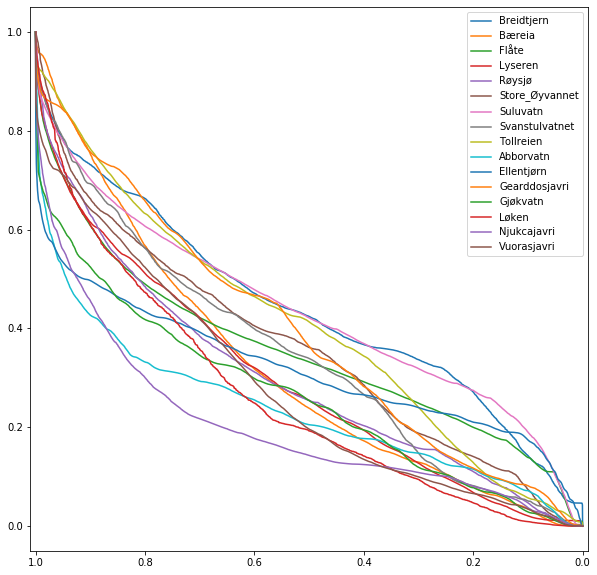

In [74]:
plt.figure(figsize=(10,10))
for key, values in ecdf.items(): 
    plt.plot(values['y'],values['x'],label=key)
    
plt.xlim([1.01,-0.01])
plt.legend(loc='upper right')

plt.savefig('hypsogram.png')

In [10]:
def getTable(query,out,headers):
    geonorge.vmScript='''#! /bin/bash
echo "\COPY ({}) TO '/home/jose-luis/{}.txt' DELIMITER ',';" | psql -d geonorway
'''.format(query,out)
    geonorge.runScript(saveFolder=scriptsFolder,scriptName='dummy.sh')
    geonorge.callPopen('fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py downloadFile:{0}.txt,{0}.txt'.format(out))
    return pd.read_csv('{}.txt'.format(out), header=None, names=headers)
    ##with pd.option_context("display.max_rows", 200):
    ##    display(landuse)

basinAreas=getTable('SELECT * FROM metno.coverage_percentage','dummy',['station','Total cover land use (km2)','Basin area (km2)', 'Coverage percentage'])
basinAreas['Basin area (km2)'] /= 1e6
basinAreas['Total cover land use (km2)'] /= 1e6
basinAreas.set_index('station',inplace=True)
display(basinAreas)
basinAreas.to_csv('areas.txt')


[35.228.105.138] Executing task 'setup'
[35.228.105.138] put: ./scripts/dummy.sh -> dummy.sh
[35.228.105.138] run: chmod +x dummy.sh
[35.228.105.138] run: ./dummy.sh
[35.228.105.138] out: COPY 16
[35.228.105.138] out: 


Done.
Disconnecting from 35.228.105.138... done.

[35.228.105.138] Executing task 'downloadFile'
[35.228.105.138] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/geonorgeCrawler/dummy.txt <- /home/jose-luis/dummy.txt

Done.
Disconnecting from 35.228.105.138... done.




,Total cover land use (km2),Basin area (km2),Coverage percentage
station,,,
Breidtjern,4.275625,4.275625,100.000000
Gearddosjavri,13.599375,13.599375,100.000000
Suluvatn,23.005624,23.005625,99.999996
Gjøkvatn,15.493125,15.493125,100.000000
Flåte,97.409546,97.451875,99.956564
Store_Øyvannet,5.200623,5.200625,99.999962
Ellentjørn,184.484661,237.983750,77.519856
Abborvatn,15.038750,15.038750,100.000000
Lyseren,28.714374,28.714375,99.999996
